# Visualizing token-level grad norms

In [1]:
import sys
sys.path.append('/home/jxm3/research/deidentification/unsupervised-deidentification')

In [2]:
from model import DocumentProfileMatchingTransformer

# model that was trained at the link given above, gets >99% validation accuracy,
# and is trained with word dropout!
checkpoint_path = '/home/jxm3/research/deidentification/unsupervised-deidentification/saves/distilbert-base-uncased__dropout_0.8_0.8/deid-wikibio_default/1irhznnp_130/checkpoints/epoch=25-step=118376.ckpt'
model = DocumentProfileMatchingTransformer.load_from_checkpoint(
    checkpoint_path,
    document_model_name_or_path='distilbert-base-uncased',
    profile_model_name_or_path='distilbert-base-uncased',
    num_workers=1,
    train_batch_size=64,
    eval_batch_size=64,
    learning_rate=1e-6,
    max_seq_length=256,
    pretrained_profile_encoder=False,
    word_dropout_ratio=0.0, word_dropout_perc=0.0,
    lr_scheduler_factor=0.5, lr_scheduler_patience=3,
    adversarial_mask_k_tokens=0
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- T

Initialized DocumentProfileMatchingTransformer with learning_rate = 1e-06


In [3]:
from datamodule import WikipediaDataModule
import os

num_cpus = os.cpu_count()

dm = WikipediaDataModule(
    mask_token=model.document_tokenizer.mask_token,
    dataset_name='wiki_bio',
    dataset_train_split='train[:10%]', # this model was trained with 100% of training data
    dataset_val_split='val[:5%]',
    dataset_version='1.2.0',
    num_workers=1,
    train_batch_size=64,
    eval_batch_size=64,
)
dm.setup("fit")

Initializing WikipediaDataModule with num_workers = 1 and mask token `[MASK]`
loading wiki_bio[1.2.0] split train[:10%]


Using custom data configuration default
Reusing dataset wiki_bio (/home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da)


loading wiki_bio[1.2.0] split val[:5%]


Using custom data configuration default
Reusing dataset wiki_bio (/home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da)
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-777e395491fb4772.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-d064080b513aa2c2.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-922e43c07424b8b2.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-61b67aa75597ecdf.arrow
Loading cached processed dataset at /h

In [12]:
import numpy as np
import torch
import tqdm

def precompute_profile_embeddings(model, datamodule):
    model.profile_model.cuda()
    model.profile_model.eval()
    # model.profile_embed.cuda()
    print('Precomputing profile embeddings before first epoch...')
    model.train_profile_embeddings = np.zeros((len(datamodule.train_dataset), model.profile_embedding_dim))
    for train_batch in tqdm.tqdm(datamodule.train_dataloader(), desc="[1/2] Precomputing train embeddings", colour="magenta", leave=False):
        with torch.no_grad():
            profile_embeddings = model.forward_profile_text(text=train_batch["profile"])
        model.train_profile_embeddings[train_batch["text_key_id"]] = profile_embeddings.cpu()
    model.train_profile_embeddings = torch.tensor(model.train_profile_embeddings, dtype=torch.float32)

    model.val_profile_embeddings = np.zeros((len(datamodule.val_dataset), model.profile_embedding_dim))
    for val_batch in tqdm.tqdm(datamodule.val_dataloader(), desc="[2/2] Precomputing val embeddings", colour="green", leave=False):
        with torch.no_grad():
            profile_embeddings = model.forward_profile_text(text=val_batch["profile"])
        model.val_profile_embeddings[val_batch["text_key_id"]] = profile_embeddings.cpu()
    model.val_profile_embeddings = torch.tensor(model.val_profile_embeddings, dtype=torch.float32)
    model.profile_model.train()

precompute_profile_embeddings(model, dm)

Precomputing profile embeddings before first epoch...


In [8]:
val_batch = next(iter(dm.val_dataloader()))
val_batch.keys()

dict_keys(['document', 'profile', 'document_redact_lexical', 'document_redact_ner', 'text_key_id'])

In [60]:
reverse_vocab = {v: k for k,v in model.document_tokenizer.vocab.items()}

In [115]:
import re

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from utils import name_from_table_rows

def plot_token_importance(i: int):
    document_inputs, document_embeddings = model.forward_document_text(val_batch['document'], return_inputs=True)
    document_inputs
    document_embeddings.shape, model.val_profile_embeddings.shape
    loss = model._compute_loss_exact(document_embeddings[None, i], model.val_profile_embeddings, val_batch['text_key_id'][None, i], metrics_key='')
    loss.backward()
    emb_norms = model.document_model.embeddings.word_embeddings.weight.grad.norm(p=2, dim=1)
    input_ids = document_inputs['input_ids'][i]
    V = len(model.document_model.embeddings.word_embeddings.weight)
    token_emb_norms = emb_norms @ (input_ids[input_ids != 0][None, :] == torch.arange(V)[:, None]).to(torch.float32)
    tokens = [reverse_vocab[x.item()] for x in input_ids[input_ids != 0]]

    df = pd.DataFrame.from_dict({ 'tokens': tokens, 'emb_norms': token_emb_norms })


    # name_from_table_rows()
    name_i = name_from_table_rows([row.split(' | ') for row in val_batch['profile'][i].split('\n')])

    plt.figure(figsize=(10,len(tokens)/2))
    sns.barplot(y='tokens', x='emb_norms', data=df).set_title(name_i)

/home/jxm3/.conda/envs/torch/lib/python3.9/site-packages/pytorch_lightning/core/lightning.py:415: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


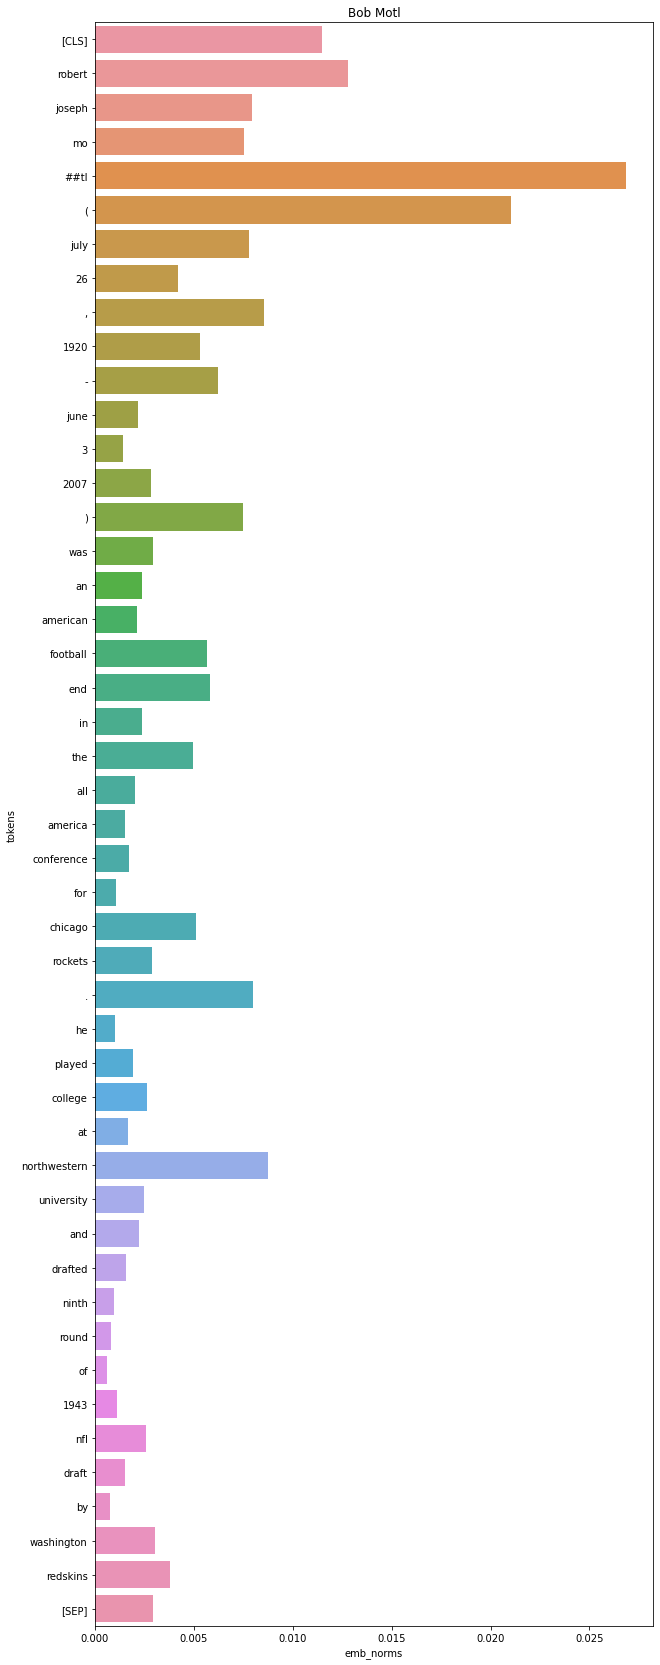

In [116]:
plot_token_importance(20)

/home/jxm3/.conda/envs/torch/lib/python3.9/site-packages/pytorch_lightning/core/lightning.py:415: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


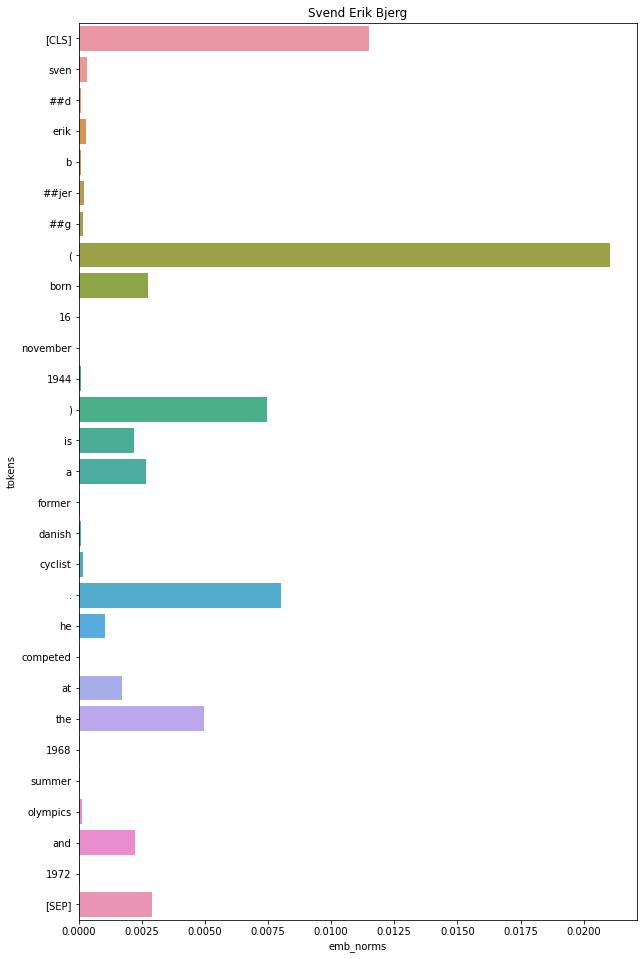

In [117]:
plot_token_importance(55)

/home/jxm3/.conda/envs/torch/lib/python3.9/site-packages/pytorch_lightning/core/lightning.py:415: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


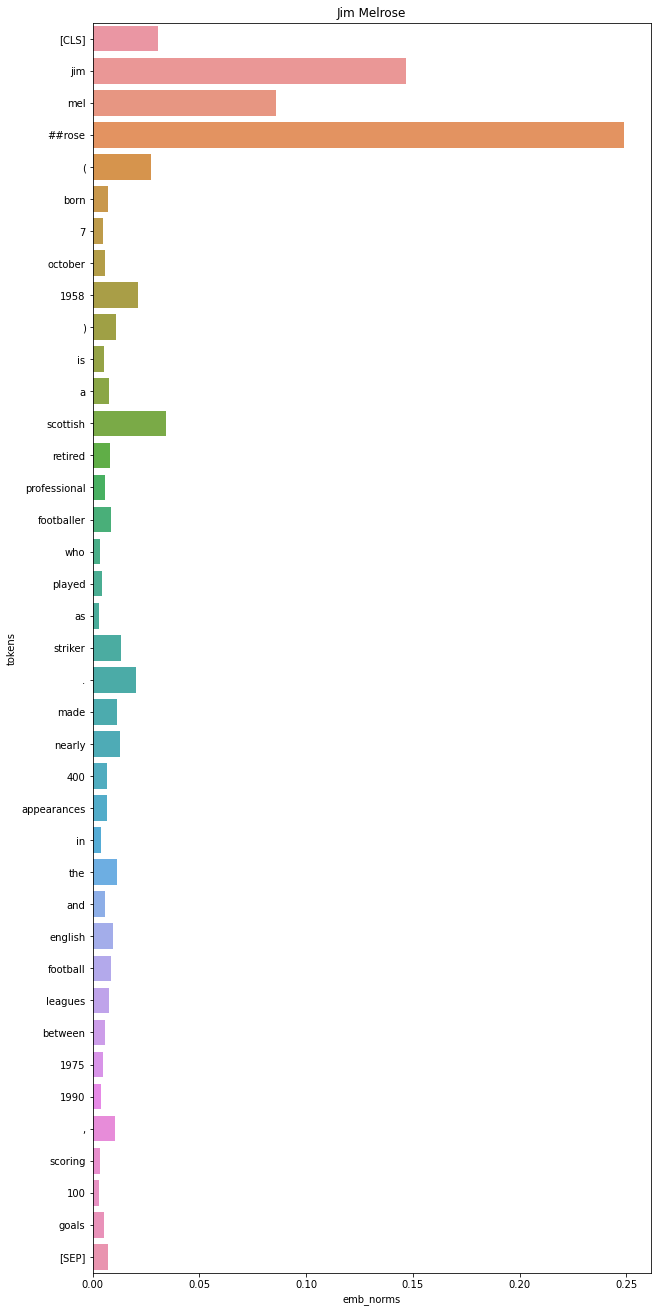

In [118]:
plot_token_importance(63)

/home/jxm3/.conda/envs/torch/lib/python3.9/site-packages/pytorch_lightning/core/lightning.py:415: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


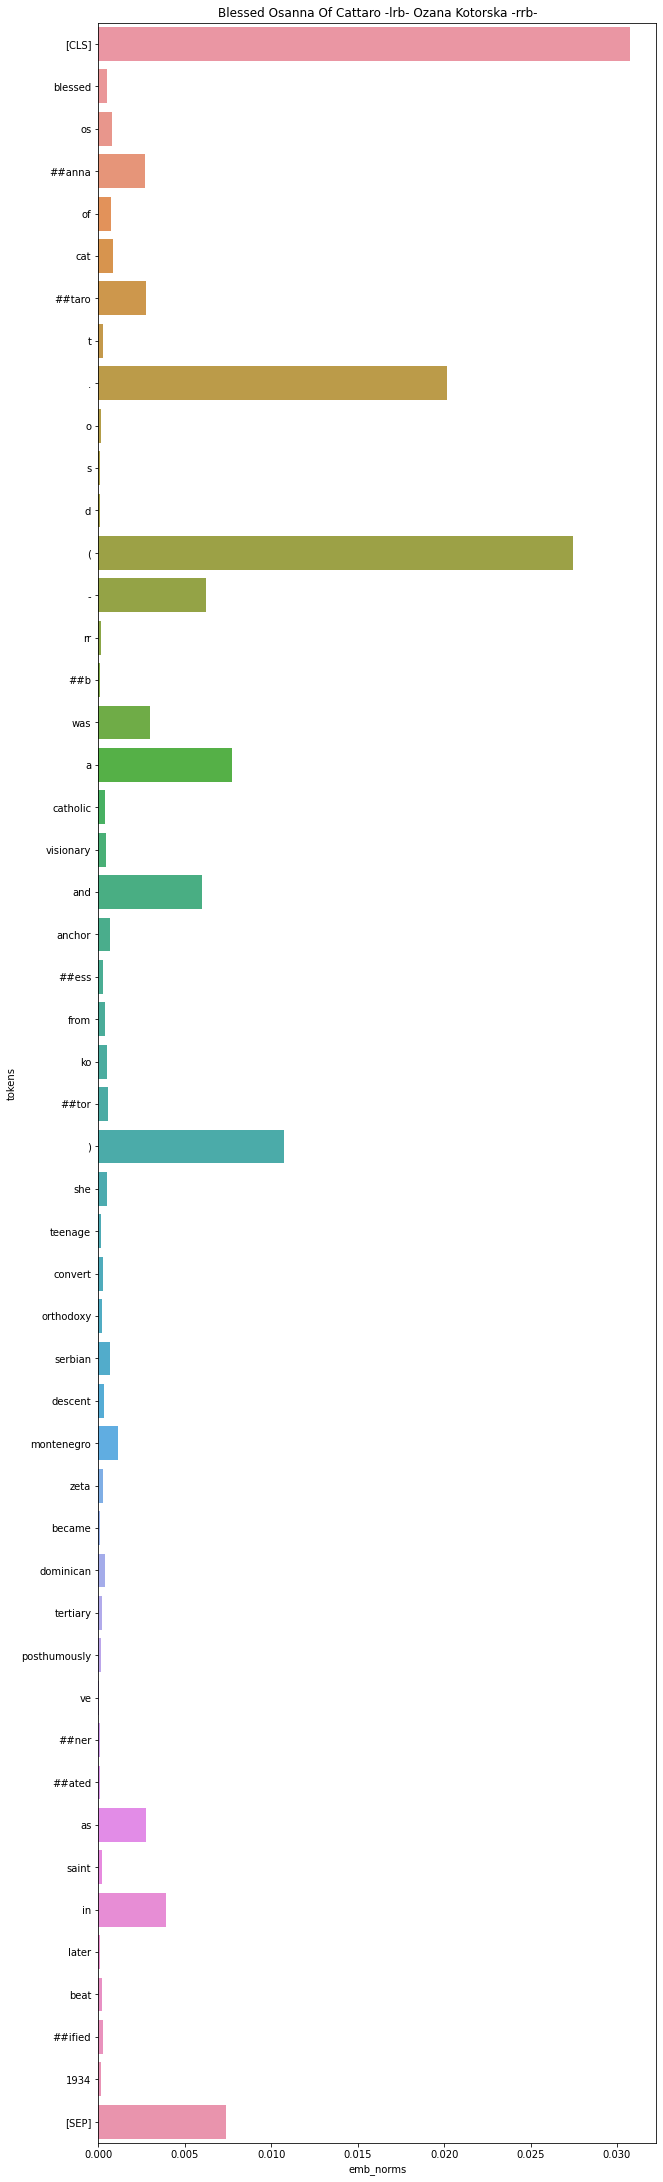

In [119]:
plot_token_importance(9)

/home/jxm3/.conda/envs/torch/lib/python3.9/site-packages/pytorch_lightning/core/lightning.py:415: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


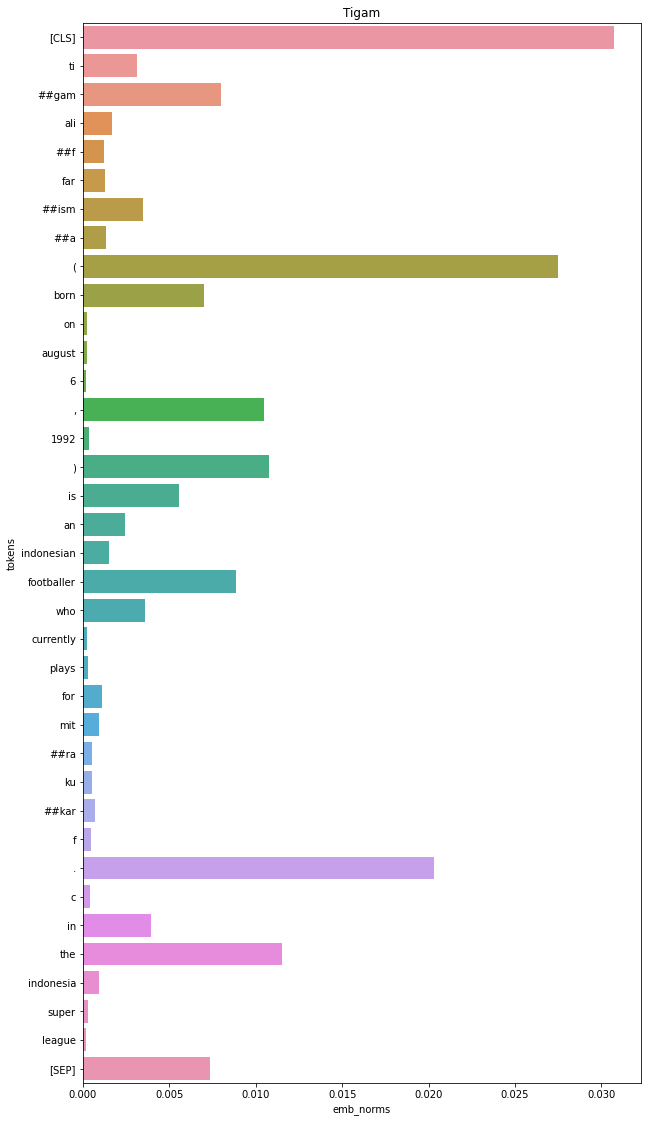

In [120]:
plot_token_importance(31)